In [10]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
from tqdm.notebook import tqdm

In [11]:
N_b = 100
N_r = 10_000

ymin,ymax=0. ,1.
xmin,xmax = 0.,2.

'''boundary conditions'''

bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)



# P[0,y] = 0
y_b1 = jax.random.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b1 = jnp.zeros_like(y_b1)
bc_1 = jnp.zeros_like(y_b1)
BC_1 = jnp.concatenate([x_b1,y_b1,bc_1],axis=1)

# P[2,y] = y
y_b2 = jax.random.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b2 = jnp.ones_like(y_b2) * 2
bc_2 = y_b2
BC_2 = jnp.concatenate([x_b2,y_b2,bc_2],axis=1)

# P_y[x,0] = 0
x_b3 = jax.random.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b3 = jnp.zeros_like(x_b3)
bc_3 = jnp.zeros_like(x_b3)
BC_3 = jnp.concatenate([x_b3,y_b3,bc_3],axis=1)

# P_y[x,1] = 0
x_b4 = jax.random.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b4 = jnp.ones_like(x_b4)
bc_4 = jnp.zeros_like(x_b4)
BC_4 = jnp.concatenate([x_b4,y_b4,bc_4],axis=1)

conds = [BC_1,BC_2,BC_3,BC_4]

#collocation points
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
colloc = jnp.concatenate([x_c,y_c],axis=1) 

def PDE_loss(x,y,u):
  u_x=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),0)(x,y)
  u_xx=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_x(x,y)),0)(x,y)

  u_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),1)(x,y)
  u_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_y(x,y)),1)(x,y)

  return u_xx(x,y) + u_yy(x,y)

In [ ]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,conds):
  x_c,y_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda x,y : fwd(params,x,y)
  ufunc_y = lambda x,y:jax.grad(lambda x,y:jnp.sum(ufunc(x,y)),1)(x,y)
  
  loss =jnp.mean(PDE_loss(x_c,y_c,ufunc) **2)

  for cond in conds[0:2] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
    loss += MSE(ufunc(x_b,y_b),u_b)
  
  for cond in conds[2:4] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
    loss += MSE(ufunc_y(x_b,y_b),u_b)

  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)
  
  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params

In [12]:
params = init_params([2]+[8]*4 + [1])
lr = optax.piecewise_constant_schedule(1e-2, {10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [15]:
epochs = 10_000
for _ in tqdm(range(epochs)):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch=0	loss=1.639e-03


KeyboardInterrupt: 

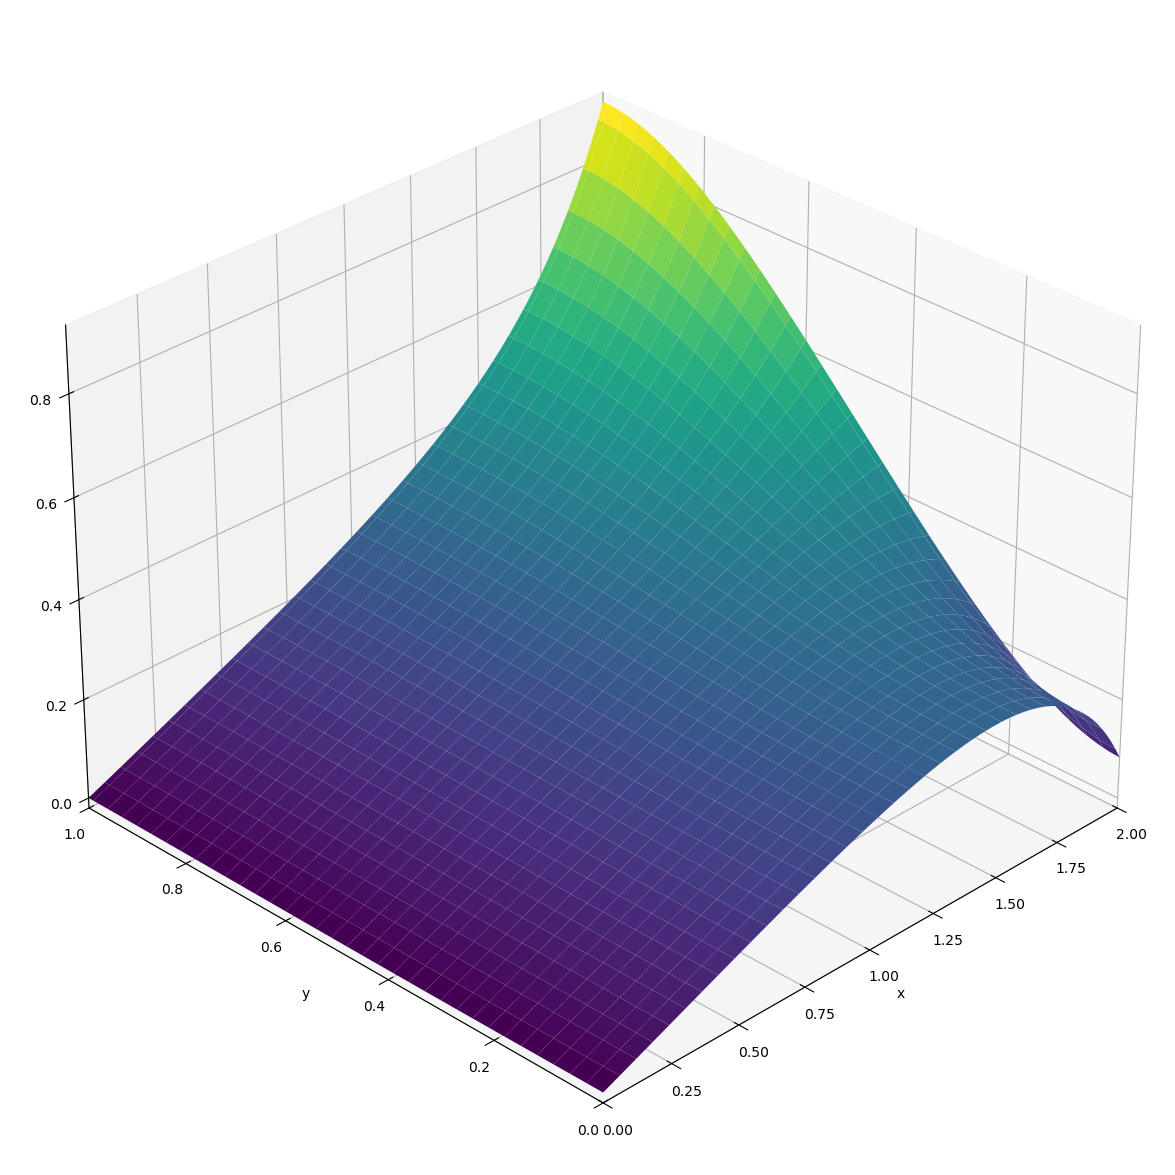

In [9]:
def plot2D(T,X, p):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

N=100
x = np.linspace(0, 2, N+1)
y = np.linspace(0, 1, N+1)
X,Y = np.meshgrid(x, y)
pred = (fwd(params,X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1))).reshape(N+1,N+1)

plot2D(X,Y,pred)